In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

%load_ext autoreload
%autoreload 2

# loading libraries, some settings for plots
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams['figure.figsize'] = [10, 10]

import sys
sys.path.insert(0, "..") 

from src.data import make_dataset
from src.visualization import visualize
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV

# Kernels, basis expansion at scale
A problem with polynomial features is that they don't scale very well. Consider this:

We generate data with 2 features, polynomial degree 2.

In [11]:
X = np.random.rand(100, 2)
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)
print(X_poly.shape)

(100, 6)


5 features, polynomial degree 5

In [12]:
X = np.random.rand(100, 5)
poly = PolynomialFeatures(5)
X_poly = poly.fit_transform(X)
print(X_poly.shape)

(100, 252)


10 features, polynomial degree 8

In [13]:
X = np.random.rand(100, 10)
poly = PolynomialFeatures(8)
X_poly = poly.fit_transform(X)
print(X_poly.shape)

(100, 43758)


As you can see, this does not scale well. If you set the features to 15 and the poly degree to 15, you will blow up the kernel due to memory shortage....
Conclusion: this grows much too hard to be feasable for sets with more then a handful of features. 

Let's have a look at a way to do basis expansions, without scaling much too hard.

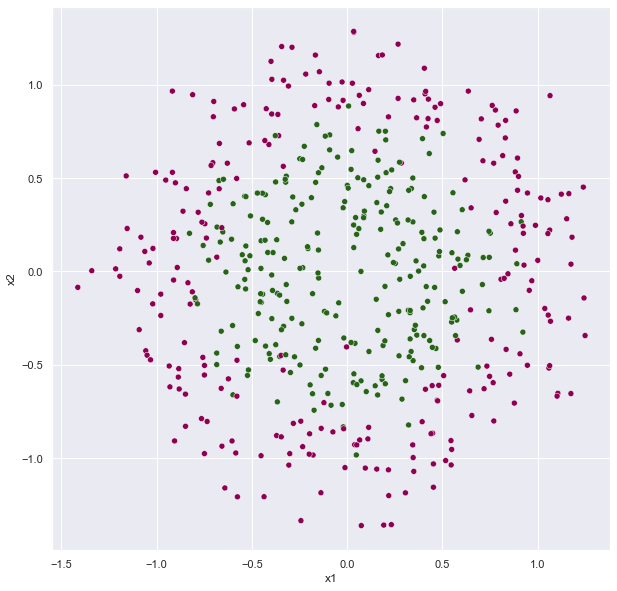

In [60]:
from sklearn.datasets import make_circles
X, y = make_circles(500, noise=0.2, factor=0.5, random_state=5)
data = pd.DataFrame({'x1': X[:,0], 'x2':X[:,1], 'y':y})
cm = plt.cm.PiYG
sns.scatterplot(data = data, x = 'x1', y = 'x2', cmap = cm, c=y);

This obviously won't work with a linear classifier. So we can do basis expansion with a kernel. Thanks to a neat mathematical trick, we can do basis expansion without actually paying the price in terms of memory and time to calculate hundreds of thousands of features. 

Obviously this wouldn't be a problem with 2D data like in this example, but this will scale regardless of the amount of features.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)

In [62]:
from sklearn.svm import SVC
pipe = Pipeline(
    [
        ("svm", SVC(kernel='rbf')) #
    ]
)

# param_grid = {'svm__C': np.linspace(1,20, 10),
#               'svm__gamma': np.linspace(0.01, 0.4, 10)}
param_grid = {'svm__C': [10**x for x in range(-4,3)],
              'svm__gamma': [10**x for x in range(-4,3)]}

gridsearch = GridSearchCV(pipe, param_grid=param_grid, cv=3)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'svm__C': 1, 'svm__gamma': 1}

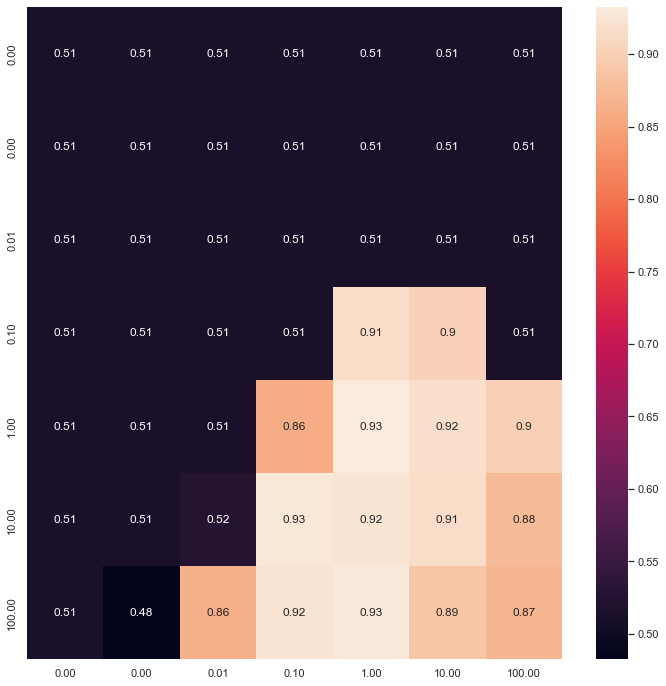

In [63]:
visualize.gridsearch_heatmap(gridsearch, param_grid)

Ok, let's fit the pipe, and collect the results with regards to the train and test set. This way we can compare different models quite easy with regards to performance and overfitting.

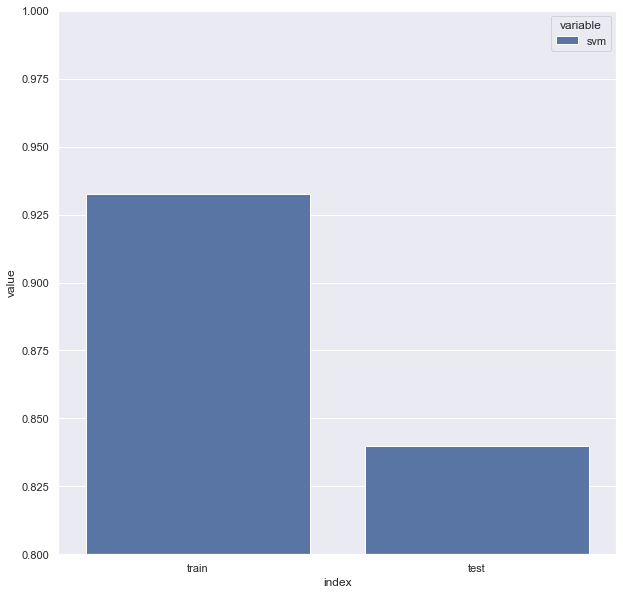

In [64]:
pipe.set_params(**gridsearch.best_params_)
pipe.fit(X_train, y_train)
results = {}
results['svm'] = pipe.score(X_train, y_train), pipe.score(X_test, y_test)
visualize.compare_results(results, ylim=0.8)

But now the question, how does the kernel work? We can plot on a grid the outcome. Below you can see the pink area, where every point inside this area will be classified as belonging to the red class. The green area will classifiy every point in that area as belonging to the green class. You can see that, due to some noise, some green point fall inside the pink area, and some red point fall into the green area.

Considering that we generated a circle with some noise, this is actually a nice approximation of the original function without noise.

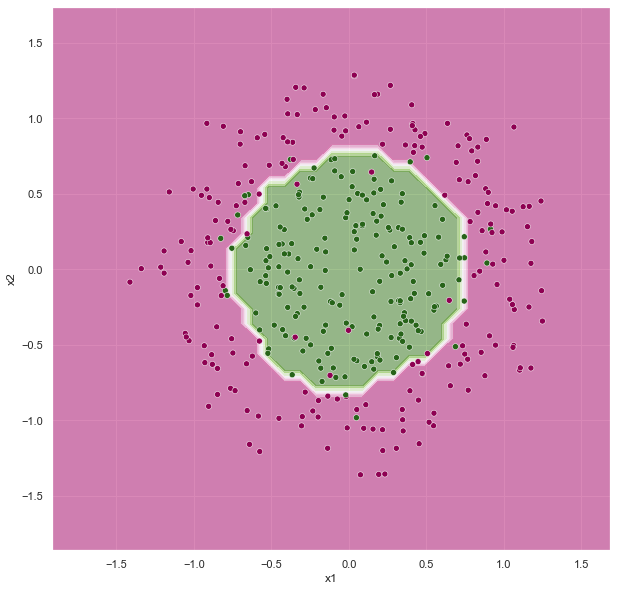

In [65]:
visualize.plot_contour(X_train, y_train, pipe)

Let's compare that to a Random Forest.

In [66]:
from sklearn.ensemble import RandomForestClassifier

# we make a pipe
pipe = Pipeline(
    [
        ("rfc", RandomForestClassifier())
    ]
)

# set a grid
param_grid = {'rfc__max_depth': np.arange(2, 50, 2),
              'rfc__n_estimators': np.arange(10, 100, 10)}

gridsearch = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=4)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'rfc__max_depth': 46, 'rfc__n_estimators': 50}

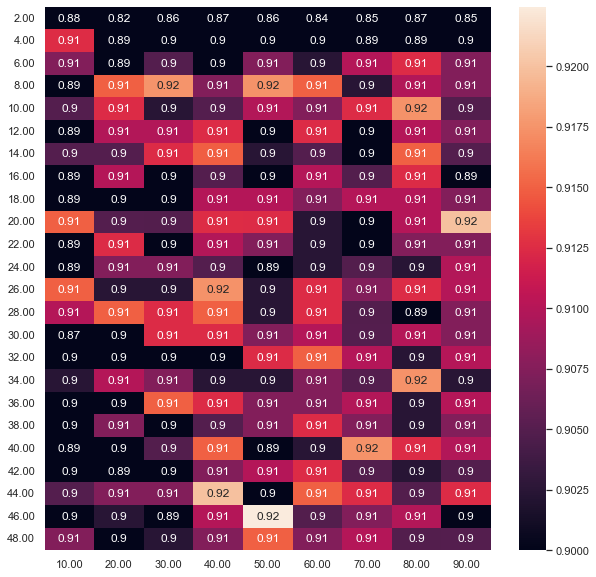

In [67]:
visualize.gridsearch_heatmap(gridsearch, param_grid, vmin = 0.9, figsize=(10,10))

The heatmap looks a bit like white noise. Everything seems sort of ok, with values around 0.9. This is typically for random forests. Now let's try to peek inside the model.

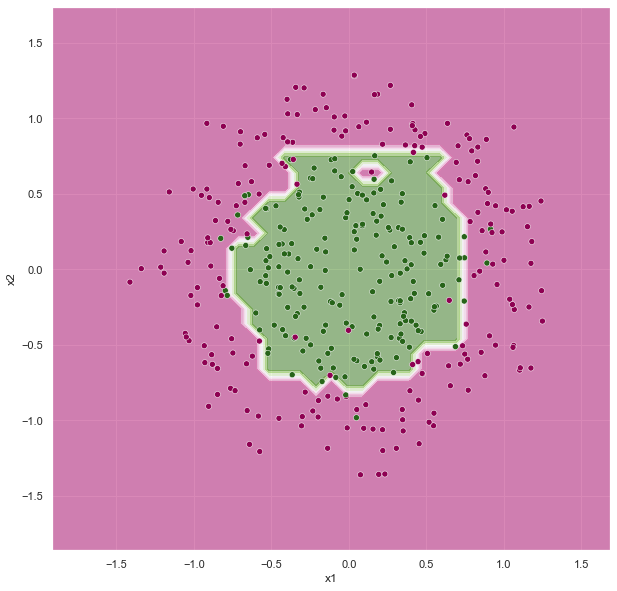

In [68]:
pipe.set_params(**gridsearch.best_params_)
pipe.fit(X_train, y_train)
visualize.plot_contour(X_train, y_train, pipe)

Hopefully, you can appreciate the difference between the SVM+kernel and this. The randomforest is overfitting. The green shape is much less like a circle. It's more a square with some rough corners, and even a small red patch inside the green area. Now let's compare this on the train-test set.

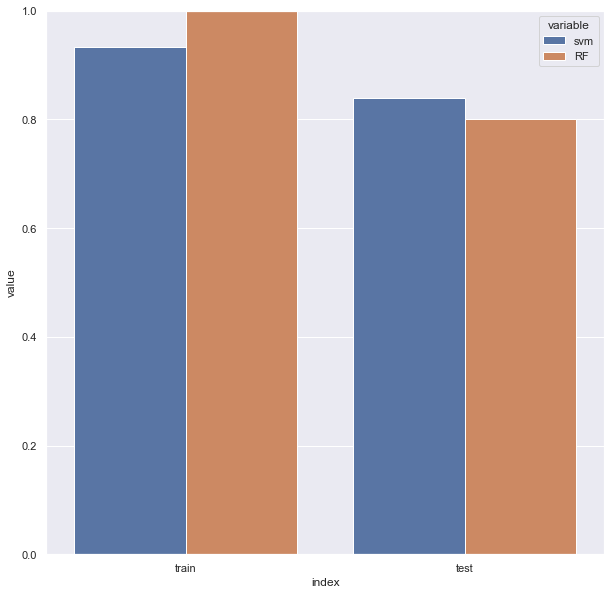

In [69]:
results['RF'] = pipe.score(X_train, y_train), pipe.score(X_test, y_test)
visualize.compare_results(results);

The random forest scores much better on the trainset, but much lower on the test set. This is a sign of overfitting; we can conclude that the randomforest is overfitting much worse on than the SVM. Also, looking at the testset, the SVM is expected to perform better. This is not just something you can see on the train-test split, but should also be able to understand based on the contour plot of the model; the SVM is much smoother, the RF is overfitting. This is typical behavior of a Random Forest. This behavior will decrease with more datapoints, where the two models will grow closer to each other. Also, under some circumstances, the Random Forest will outperform the SVM. This depends on parameters like : amount of features, amount of observations, your skills in hyperparameter tuning.